# **Paths & dataset directories**

Set base path to the Kaggle dataset and define train/test folders for images and masks.
Note: All later path usage should reference these variables to avoid duplication.

In [3]:
base_path = '/kaggle/input/fetal-head-abnormalities/Dataset'
train_img_dir = f'{base_path}/train/images'   # training images
train_mask_dir = f'{base_path}/train/masks'   # corresponding masks
test_img_dir = f'{base_path}/test'            # test images


# **Quick mask binarization sanity check** (fixed vs. Otsu)

Loads one example mask and compares:

Fixed threshold (e.g., >110) vs.

Otsu’s adaptive thresholding (cv2.THRESH_OTSU).
Displays raw mask and binarized outputs to confirm mask quality.

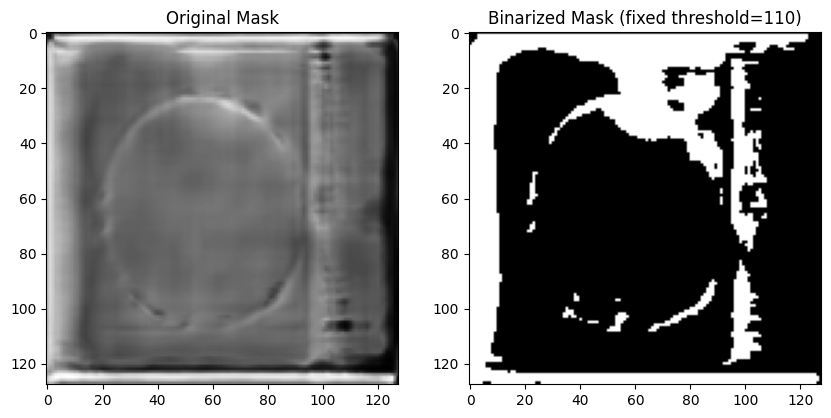

Unique values in mask (fixed threshold): [0 1]


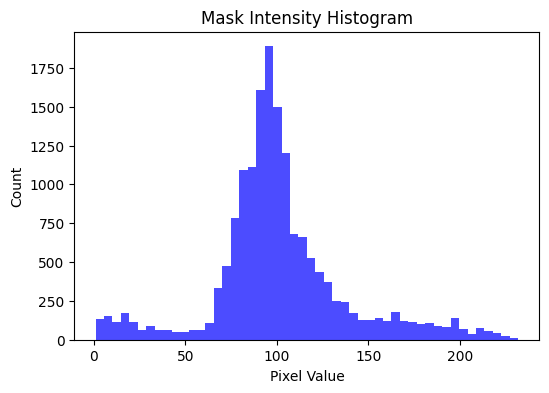

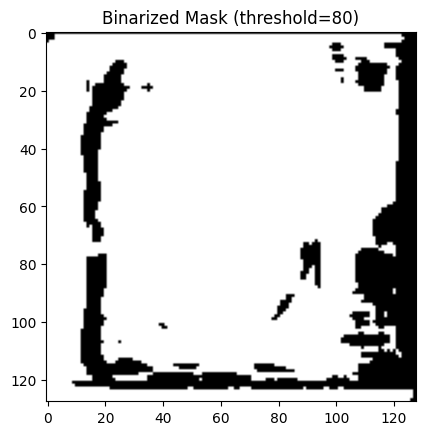

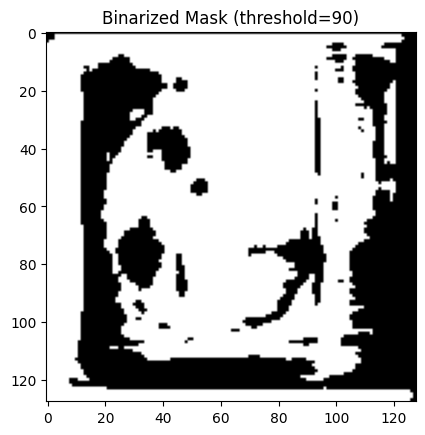

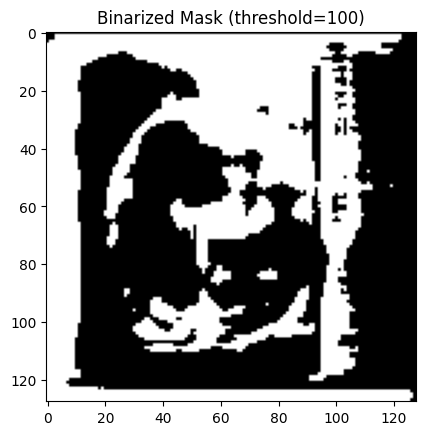

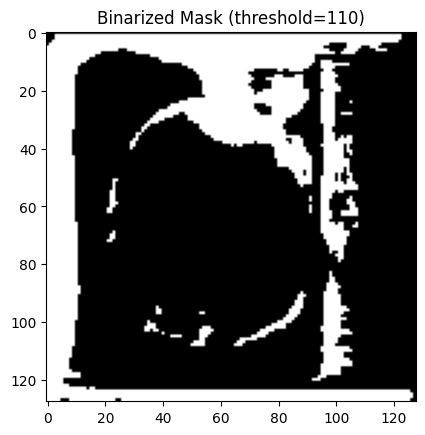

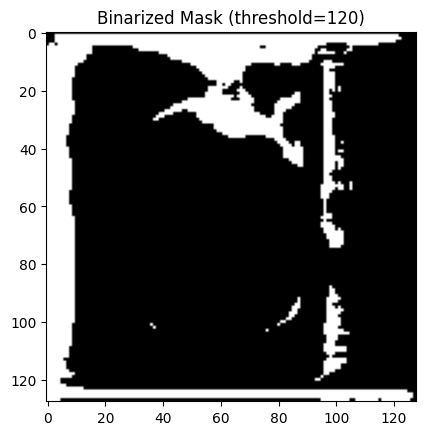

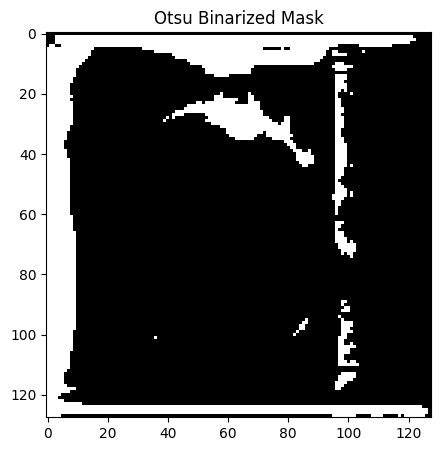

Unique values in mask (Otsu): [0 1]


In [4]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2  # Make sure OpenCV is imported for Otsu's threshold

example_mask_path = os.path.join(train_mask_dir, os.listdir(train_mask_dir)[0])
mask = Image.open(example_mask_path).convert('L')
mask_arr = np.array(mask)

# Fixed threshold binarization (your current method)
mask_bin_fixed = (mask_arr > 110).astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mask_arr, cmap='gray')
plt.title('Original Mask')
plt.subplot(1,2,2)
plt.imshow(mask_bin_fixed, cmap='gray')
plt.title('Binarized Mask (fixed threshold=110)')
plt.show()
print("Unique values in mask (fixed threshold):", np.unique(mask_bin_fixed))  # expect [0, 1]

# -----------------------------------------
# New Part: Intensity histogram analysis
plt.figure(figsize=(6,4))
plt.hist(mask_arr.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Mask Intensity Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Count")
plt.show()

for t in [80, 90, 100, 110, 120]:
    mask_bin = (mask_arr > t).astype(np.uint8)
    plt.imshow(mask_bin, cmap='gray')
    plt.title(f'Binarized Mask (threshold={t})')
    plt.show()


# New Part: Otsu's adaptive threshold binarization
_, mask_bin_otsu = cv2.threshold(mask_arr, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(5,5))
plt.imshow(mask_bin_otsu, cmap='gray')
plt.title('Otsu Binarized Mask')
plt.show()

print("Unique values in mask (Otsu):", np.unique(mask_bin_otsu))


# Custom FetalSegmentationDataset

Pairs images with masks using the provided mapping.

Converts masks to binary (threshold = 110).

Applies separate transforms to image and mask.
Tip: For geometric transforms, apply the same random ops to both image and mask.

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

class FetalSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, pairs, transform_img=None, transform_mask=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.pairs = list(pairs.items())
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load mask and binarize with threshold 110
        mask = Image.open(mask_path).convert('L')
        mask_array = np.array(mask)
        mask_bin = (mask_array > 110).astype(np.float32)
        mask_bin = Image.fromarray(mask_bin)

        # Apply transforms
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask_bin = self.transform_mask(mask_bin)

        return image, mask_bin


# Build image↔mask pairs

Extract numeric suffix from filenames to match images with their masks.

Creates image_to_mask dict and prints total pairs.

In [6]:
import re
import os

def get_suffix(filename):
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

train_img_dir = '/kaggle/input/fetal-head-abnormalities/Dataset/train/images'
train_mask_dir = '/kaggle/input/fetal-head-abnormalities/Dataset/train/masks'

image_files = sorted(os.listdir(train_img_dir))
mask_files = sorted(os.listdir(train_mask_dir))
image_to_mask = {}

for img in image_files:
    suffix = get_suffix(img)
    matching = [m for m in mask_files if get_suffix(m) == suffix]
    if matching:
        image_to_mask[img] = matching[0]

print(f"Total image-mask pairs: {len(image_to_mask)}")


Total image-mask pairs: 1998


# Transforms & paired augmentation helper

Image pipeline: resize → color jitter → tensor → normalize.

Mask pipeline: resize → tensor (binary).

RandomRotateFlip shows how to apply the same random geometry to both image and mask.

In [7]:
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

class RandomRotateFlip:
    def __call__(self, img, mask):
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        if random.random() > 0.5:
            angle = random.uniform(-20, 20)
            img = TF.rotate(img, angle)
            mask = TF.rotate(mask, angle)
        return img, mask

train_transform_img = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_transform_mask = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# To apply same random rotation+flip to img and mask, use custom dataset __getitem__ logic incorporating RandomRotateFlip


In [15]:
import torchvision.transforms as T

# Image transforms (resize + convert to tensor + normalize)
transform_img = T.Compose([
    T.Resize((256, 256)),  # adjust size as needed
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # assuming grayscale fetal head scans
])

# Mask transforms (resize + tensor, no normalization)
transform_mask = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])


# Build training dataset & loader

Instantiates FetalSegmentationDataset with the train transforms and creates a DataLoader.

In [18]:
import torchvision.transforms as T

# Image transforms
transform_img = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])   # grayscale normalization
])

# Mask transforms
transform_mask = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])


In [21]:
# Build pairs as a dict, not a list
pairs = {
    img: mask
    for img, mask in image_to_mask.items()
}
print(f"Total pairs created: {len(pairs)}")


Total pairs created: 1998


In [22]:
train_dataset = FetalSegmentationDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    pairs=pairs,
    transform_img=transform_img,
    transform_mask=transform_mask
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 1998


# Model architecture (current: custom U-Net)

Defines a standard U-Net encoder–decoder with skip connections.
Note: Notebook title mentions UNeXt—either implement UNeXt or rename to U-Net to avoid confusion.

In [10]:
!pip install -q segmentation-models-pytorch


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.dconv_down1 = DoubleConv(n_channels, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        # Decoder
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return out


**Loss & optimizer**

Loss: BCEWithLogitsLoss for binary segmentation.

Optimizer: Adam with lr = 1e-4.

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Device selection

Use CUDA if available, else CPU.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)


# Metrics: Dice & IoU (PyTorch)

Implements differentiable Dice and IoU on tensors for validation reporting.

In [16]:
import torch

def dice_coefficient(preds, targets, smooth=1e-6):
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, smooth=1e-6):
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


# Train/val split & DataLoaders

80/20 split of the full training set; creates train_loader and val_loader.

In [22]:
from torch.utils.data import random_split, DataLoader

# Assuming you have `train_dataset` defined with all data
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)


# Validation loop (one epoch)

model.eval() with torch.no_grad().

Computes loss, thresholded predictions, Dice, and IoU.

Returns epoch loss + averaged metrics.

**Progress bar**

Import tqdm for train/val loops.

In [24]:
from tqdm import tqdm


In [23]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs) > 0.5

            dice = dice_coefficient(preds, masks)
            iou = iou_score(preds, masks)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)

    return epoch_loss, mean_dice, mean_iou


# Training loop (one epoch)

model.train(); zero grad → forward → loss → backward → step.

Returns average training loss.

In [25]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        #outputs = outputs.squeeze(1)  # Shape: (batch, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


# > Training driver (multi-epoch)

Runs train_one_epoch() and validate_one_epoch() for num_epochs, logging loss, Dice, IoU.

In [26]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss, val_dice, val_iou = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")



Epoch 1/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Training Loss: 0.1973


100%|██████████| 25/25 [00:02<00:00, 11.46it/s]


Validation Loss: 0.1828, Dice: 0.8897, IoU: 0.8019

Epoch 2/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Training Loss: 0.1729


100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


Validation Loss: 0.1707, Dice: 0.8897, IoU: 0.8018

Epoch 3/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Training Loss: 0.1557


100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


Validation Loss: 0.1540, Dice: 0.8938, IoU: 0.8086

Epoch 4/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Training Loss: 0.1416


100%|██████████| 25/25 [00:02<00:00, 11.49it/s]


Validation Loss: 0.1472, Dice: 0.8983, IoU: 0.8160

Epoch 5/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Training Loss: 0.1304


100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


Validation Loss: 0.1416, Dice: 0.8972, IoU: 0.8142

Epoch 6/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Training Loss: 0.1209


100%|██████████| 25/25 [00:02<00:00, 11.08it/s]


Validation Loss: 0.1360, Dice: 0.8984, IoU: 0.8162

Epoch 7/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Training Loss: 0.1124


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


Validation Loss: 0.1376, Dice: 0.8976, IoU: 0.8148

Epoch 8/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Training Loss: 0.1048


100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


Validation Loss: 0.1374, Dice: 0.8964, IoU: 0.8130

Epoch 9/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Training Loss: 0.0978


100%|██████████| 25/25 [00:02<00:00, 11.41it/s]


Validation Loss: 0.1325, Dice: 0.8991, IoU: 0.8173

Epoch 10/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Training Loss: 0.0910


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


Validation Loss: 0.1328, Dice: 0.8986, IoU: 0.8165

Epoch 11/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Training Loss: 0.0853


100%|██████████| 25/25 [00:02<00:00, 11.53it/s]


Validation Loss: 0.1336, Dice: 0.8980, IoU: 0.8155

Epoch 12/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Training Loss: 0.0797


100%|██████████| 25/25 [00:02<00:00, 11.20it/s]


Validation Loss: 0.1369, Dice: 0.8964, IoU: 0.8129

Epoch 13/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Training Loss: 0.0748


100%|██████████| 25/25 [00:02<00:00, 10.99it/s]


Validation Loss: 0.1364, Dice: 0.8982, IoU: 0.8158

Epoch 14/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Training Loss: 0.0707


100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Validation Loss: 0.1393, Dice: 0.8995, IoU: 0.8180

Epoch 15/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Training Loss: 0.0668


100%|██████████| 25/25 [00:02<00:00, 10.73it/s]


Validation Loss: 0.1401, Dice: 0.8986, IoU: 0.8164

Epoch 16/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Training Loss: 0.0632


100%|██████████| 25/25 [00:02<00:00, 10.80it/s]


Validation Loss: 0.1432, Dice: 0.8984, IoU: 0.8161

Epoch 17/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Training Loss: 0.0597


100%|██████████| 25/25 [00:02<00:00, 11.02it/s]


Validation Loss: 0.1434, Dice: 0.8988, IoU: 0.8168

Epoch 18/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Training Loss: 0.0569


100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


Validation Loss: 0.1472, Dice: 0.8967, IoU: 0.8134

Epoch 19/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Training Loss: 0.0546


100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


Validation Loss: 0.1486, Dice: 0.8986, IoU: 0.8164

Epoch 20/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Training Loss: 0.0526


100%|██████████| 25/25 [00:02<00:00, 11.03it/s]

Validation Loss: 0.1490, Dice: 0.8985, IoU: 0.8163


# Visualization utility: predictions vs. ground truth

Plots a few samples (num_samples) showing: input, GT mask, predicted mask (thresholded).

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, num_samples * 4))

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold prediction

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                
                img = images[i].cpu().permute(1, 2, 0).numpy()  # HWC
                img = (img * 0.5) + 0.5  # Unnormalize if normalized
                img = np.clip(img, 0, 1)

                mask_gt = masks[i].cpu().squeeze().numpy()
                mask_pred = preds[i].cpu().squeeze().numpy()

                plt.subplot(num_samples, 3, images_shown * 3 + 1)
                plt.imshow(img)
                plt.title('Ultrasound Image')
                plt.axis('off')

                plt.subplot(num_samples, 3, images_shown * 3 + 2)
                plt.imshow(mask_gt, cmap='gray')
                plt.title('Ground Truth Mask')
                plt.axis('off')

                plt.subplot(num_samples, 3, images_shown * 3 + 3)
                plt.imshow(mask_pred, cmap='gray')
                plt.title('Predicted Mask')
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()


**Visualize a batch of predictions**

Calls the visualization function on the validation loader.

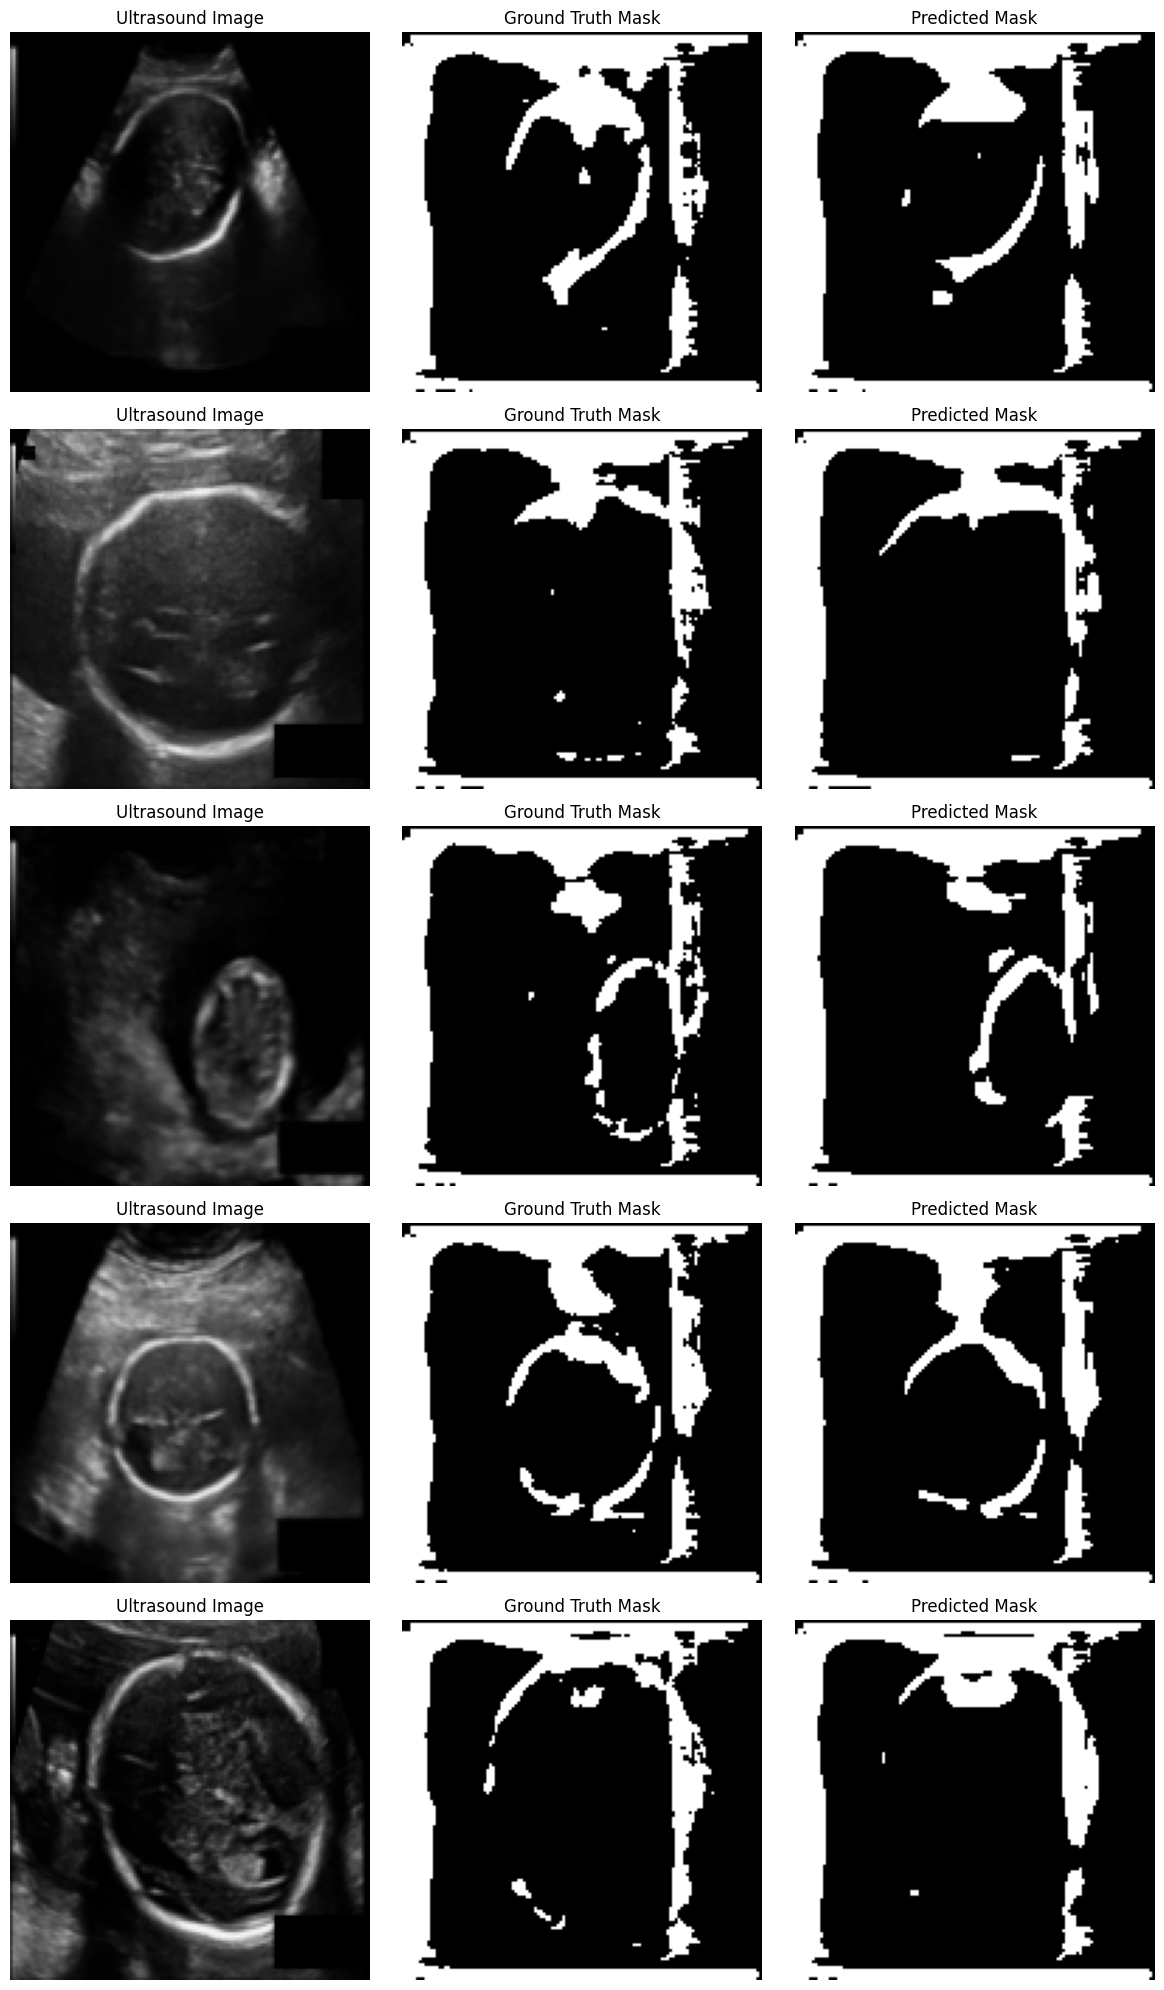

In [28]:
visualize_predictions(model, val_loader, device, num_samples=5)


**Load model weights**

Loads best_model.pth into the current model.

In [41]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


UNet(
  (dconv_down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1

# Post-processing: morphological clean-up

Applies opening and closing with a small kernel to reduce noise and holes in predicted masks.

In [51]:
def refined_post_process_mask(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8) * 255
    kernel = np.ones((2, 2), np.uint8)  # smaller kernel than before
    clean_mask = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel, iterations=1)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return clean_mask / 255


# Training with best-model checkpointing

Standard multi-epoch loop. Saves weights when validation Dice improves.

In [53]:
best_dice = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss, val_dice, val_iou = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_unet_fetal_head.pth")
        print("Saved best model")



Epoch 1/20


Training: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Training Loss: 0.0346


100%|██████████| 25/25 [00:02<00:00,  9.77it/s]


Validation Loss: 0.1735, Dice: 0.8996, IoU: 0.8181
Saved best model

Epoch 2/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.61it/s]


Validation Loss: 0.1732, Dice: 0.8996, IoU: 0.8182
Saved best model

Epoch 3/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Training Loss: 0.0347


100%|██████████| 25/25 [00:02<00:00, 11.51it/s]


Validation Loss: 0.1733, Dice: 0.8997, IoU: 0.8182
Saved best model

Epoch 4/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Training Loss: 0.0347


100%|██████████| 25/25 [00:02<00:00, 11.35it/s]


Validation Loss: 0.1735, Dice: 0.8996, IoU: 0.8181

Epoch 5/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Validation Loss: 0.1734, Dice: 0.8996, IoU: 0.8181

Epoch 6/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Validation Loss: 0.1734, Dice: 0.8997, IoU: 0.8182
Saved best model

Epoch 7/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.46it/s]


Validation Loss: 0.1736, Dice: 0.8996, IoU: 0.8181

Epoch 8/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Training Loss: 0.0349


100%|██████████| 25/25 [00:02<00:00, 11.34it/s]


Validation Loss: 0.1733, Dice: 0.8997, IoU: 0.8182
Saved best model

Epoch 9/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Training Loss: 0.0349


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Validation Loss: 0.1736, Dice: 0.8996, IoU: 0.8181

Epoch 10/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Training Loss: 0.0346


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Validation Loss: 0.1735, Dice: 0.8996, IoU: 0.8181

Epoch 11/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Validation Loss: 0.1733, Dice: 0.8996, IoU: 0.8182

Epoch 12/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Validation Loss: 0.1733, Dice: 0.8996, IoU: 0.8181

Epoch 13/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Training Loss: 0.0349


100%|██████████| 25/25 [00:02<00:00, 11.65it/s]


Validation Loss: 0.1738, Dice: 0.8996, IoU: 0.8180

Epoch 14/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.50it/s]


Validation Loss: 0.1733, Dice: 0.8996, IoU: 0.8181

Epoch 15/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Training Loss: 0.0347


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Validation Loss: 0.1736, Dice: 0.8996, IoU: 0.8181

Epoch 16/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Validation Loss: 0.1733, Dice: 0.8996, IoU: 0.8181

Epoch 17/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


Validation Loss: 0.1731, Dice: 0.8997, IoU: 0.8183
Saved best model

Epoch 18/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Training Loss: 0.0347


100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Validation Loss: 0.1736, Dice: 0.8997, IoU: 0.8182

Epoch 19/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Training Loss: 0.0347


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Validation Loss: 0.1732, Dice: 0.8997, IoU: 0.8182

Epoch 20/20


Training: 100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Training Loss: 0.0348


100%|██████████| 25/25 [00:02<00:00, 11.58it/s]

Validation Loss: 0.1734, Dice: 0.8997, IoU: 0.8182


In [29]:
torch.save(model.state_dict(), 'best_unet_fetal_head.pth')


Why 125 batches per epoch with 1,998 images?
The formula to calculate number of batches is:

Number of batches
=
⌈
dataset size
batch size
⌉
Number of batches=⌈ 
batch size
dataset size
 ⌉
Given:

Dataset size = 1,998 images

Number of batches = 125 (from training output)

So,

batch size
≈
1998
125
=
15.98
≈
16
batch size≈ 
125
1998
 =15.98≈16
This means your training DataLoader likely uses a batch size of 16.

In [55]:
print(train_loader.batch_size)  # should output 16


16


# Inference transforms

Use the same resizing and normalization as training/validation to ensure consistent model inputs.

In [57]:
from torchvision import transforms

inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# **Implement infer_image(model, image_pil, device)**
Returns a cleaned binary mask (uint8) using morphological open/close.

In [58]:
import torch
import numpy as np
import cv2

def infer_image(model, image_pil, device):
    # Preprocess image
    input_tensor = inference_transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output) > 0.5
        pred_mask = pred_mask.squeeze(0).squeeze(0).cpu()

    # Post-process mask to clean noise
    mask_np = pred_mask.numpy().astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel, iterations=2)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return clean_mask


# Using the inference helper
Demonstrate loading weights and running inference on a few samples.

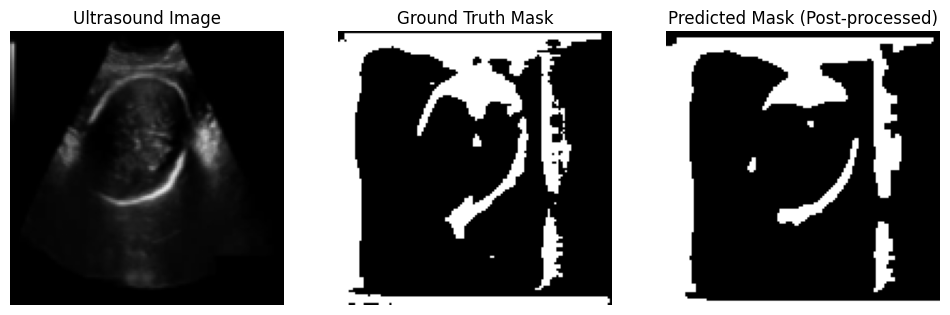

In [60]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make sure the model is loaded and on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_unet_fetal_head.pth", map_location=device))
model.to(device)
model.eval()

# Post-processing function to clean predicted mask
def post_process_mask(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8)*255
    kernel = np.ones((3,3), np.uint8)
    clean_mask = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel, iterations=2)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return clean_mask / 255

# Function to run inference on a single batch sample from validation loader
def visualize_val_sample(idx=0):
    images, masks = next(iter(val_loader))  # get one batch of validation data
    image = images[idx].to(device)          # select sample idx from batch
    mask_gt = masks[idx].to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        pred_mask = torch.sigmoid(output) > 0.5
        pred_mask = pred_mask.squeeze(0).squeeze(0).cpu()

    # Post-process predicted mask
   pred_mask_clean = post_process_mask(pred_mask)

    # Prepare images for display
    image_np = image.cpu().permute(1,2,0).numpy()
    image_np = (image_np * 0.5) + 0.5  # unnormalize
    image_np = np.clip(image_np, 0, 1)
    mask_gt_np = mask_gt.squeeze(0).cpu().numpy()

    # Plot ultrasound, ground truth and predicted mask
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image_np)
    plt.title("Ultrasound Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask_gt_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred_mask_clean, cmap='gray')
    plt.title("Predicted Mask (Post-processed)")
    plt.axis('off')

    plt.show()

# Call function to visualize the first sample (index 0)
visualize_val_sample(idx=0)


**Example: visualize inference on a validation sample**

Loads best_unet_fetal_head.pth, runs inference on one sample, applies post-processing, and plots image / GT / prediction.

**Save a batch of predicted masks as PNG**

Iterates over a loader and writes thresholded predictions to predicted_masks/.

In [61]:
import os
from torchvision.utils import save_image

# Create directory to save masks if not exists
os.makedirs("predicted_masks", exist_ok=True)

def save_batch_predictions(model, dataloader, device, save_dir="predicted_masks"):
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold mask

            for i in range(images.size(0)):
                pred_mask = preds[i].cpu().float()  # (1, H, W)

                # Optional: post-process mask here
                # pred_mask = torch.tensor(refined_post_process_mask(pred_mask.squeeze(0)))

                # Save mask as PNG image (normalizing 0-1)
                file_path = os.path.join(save_dir, f"mask_batch{batch_idx}_img{i}.png")
                save_image(pred_mask, file_path)

    print(f"Saved predicted masks in directory: {save_dir}")

# Run this function on validation data
save_batch_predictions(model, val_loader, device)


Saved predicted masks in directory: predicted_masks


**Save a batch of predicted masks as .npy**

Same as previous cell but stores masks as NumPy arrays for downstream use.

In [62]:
def save_batch_predictions_npy(model, dataloader, device, save_dir="predicted_masks_npy"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            for i in range(images.size(0)):
                pred_mask = preds[i].cpu().squeeze(0).numpy().astype(np.uint8)
                file_path = os.path.join(save_dir, f"mask_batch{batch_idx}_img{i}.npy")
                np.save(file_path, pred_mask)

    print(f"Saved predicted masks as npy files in directory: {save_dir}")

# Run this function if desired
save_batch_predictions_npy(model, val_loader, device)


Saved predicted masks as npy files in directory: predicted_masks_npy


# Visualization loop with metrics

Plots image/GT/pred after cleaning; computes Dice/IoU.

Validation average Dice: 0.7476 ± 0.0203
Validation average IoU: 0.5974 ± 0.0259


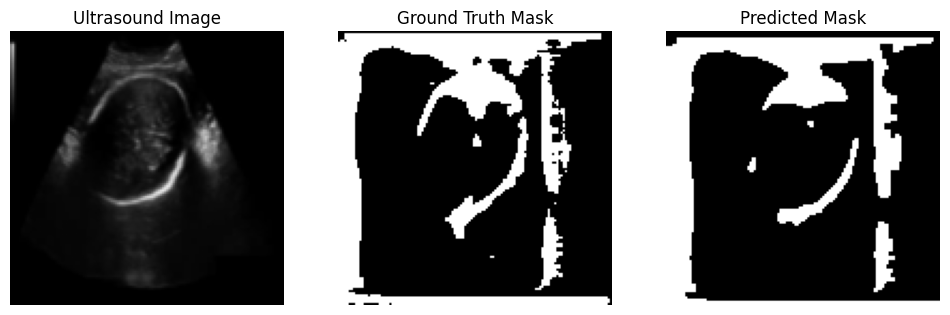

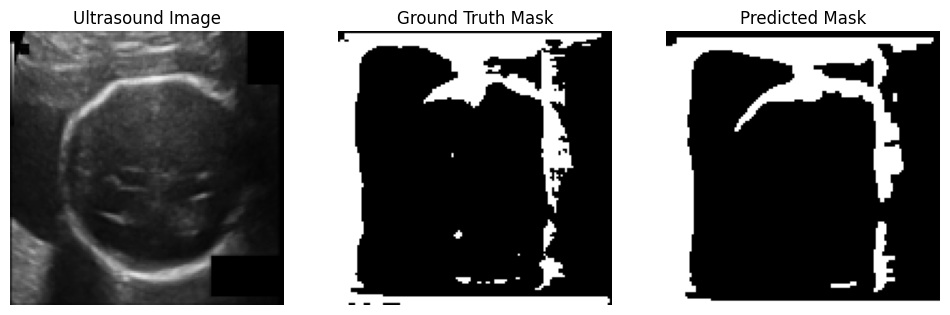

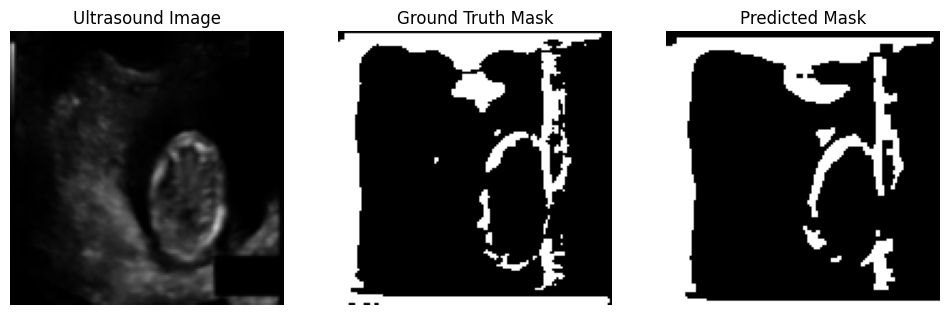

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Dice and IoU functions
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    return (2. * intersection) / (np.sum(pred) + np.sum(target) + 1e-7)

def iou_score(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return intersection / (union + 1e-7)

# Post-processing function
def refined_post_process_mask(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8) * 255
    kernel = np.ones((2, 2), np.uint8)
    clean_mask = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel, iterations=1)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return clean_mask / 255

# Evaluate on validation set
model.eval()
dices, ious = [], []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        for pred, gt in zip(preds, masks):
            pred_clean = refined_post_process_mask(pred.squeeze(0))
            gt_np = gt.cpu().numpy().squeeze(0) > 0.5

            dices.append(dice_coefficient(pred_clean.flatten(), gt_np.flatten()))
            ious.append(iou_score(pred_clean.flatten(), gt_np.flatten()))

print(f"Validation average Dice: {np.mean(dices):.4f} ± {np.std(dices):.4f}")
print(f"Validation average IoU: {np.mean(ious):.4f} ± {np.std(ious):.4f}")

# Visualize sample validation images with masks
def visualize_val_samples(num_samples=3):
    samples = list(val_loader)
    for i in range(num_samples):
        images, masks = samples[0]
        image = images[i].cpu().permute(1,2,0).numpy()
        image = (image * 0.5) + 0.5  # unnormalize
        gt_mask = masks[i].cpu().numpy().squeeze(0)

        with torch.no_grad():
            output = model(images[i].unsqueeze(0).to(device))
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze(0).squeeze(0).cpu()
            pred_clean = refined_post_process_mask(pred_mask)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title("Ultrasound Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_clean, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

visualize_val_samples()
